Download the dataset here -> https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

File Hirearchy -> Voice_Processing/data/...(paste the downloaded, extracted 3 files here)

In [72]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
print(tf.__version__)
print(tfio.__version__)
print(tf.config.list_logical_devices('GPU'))

2.10.0
0.27.0
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [73]:
# import tensorflow as tf
# # tf.keras.backend.clear_session()
# # # Maximizing GPU's memory usage
# 
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#   except RuntimeError as e:
#     print(e)
# 
# # # import tensorflow as tf
# # # 
# # # gpus = tf.config.list_physical_devices('GPU')
# # # if gpus:
# # #   try:
# # #     tf.config.set_logical_device_configuration(
# # #         gpus[0],
# # #         [tf.config.LogicalDeviceConfiguration(memory_limit=4000)]) #set the limit to 1024 Mb.
# # #   except RuntimeError as e:
# # #     # Virtual devices must be set before GPUs have been initialized
# # #     print(e)

### Loading the Dataset

Getting the data in a pictorial representation or in a tensor graph, so that we can use Image classification 

In [74]:
CAPUCHIN_FILE  = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [75]:
# Not working for me

# # loading the encoded wav file
# file_contents = tf.io.read_file(CAPUCHIN_FILE)
# # decoding the encoded file
# wav, sample_Rate = tf.audio.decode_wav(file_contents, desired_channels=1)
# print(wav)  
# 
# wav = tf.squeeze(wav, axis=-1)
# print("\nAfter Squeezing: \n", wav)  
# 
# sample_Rate = tf.cast(sample_Rate, dtype=tf.int64)
# print(sample_Rate)
# 
# wav = tfio.audio.resample(wav, rate_in=sample_Rate, rate_out=1600)

In [76]:
def load_wav_16k_mono(filename):
    # Loading the encoded file
    file_contents = tf.io.read_file(filename)

    # Decoding the encoded file
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    # Reducing Dimensions
    wav = tf.squeeze(wav, -1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # print(wav.shape)

    # Resample to whatever the current frequency is to 16000Hz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav


In [77]:
# def load_wav_16k_mono(filename):
#     # Loading the encoded file
#     file_contents = tf.io.read_file(filename)
# 
#     # Decoding the encoded file
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
# 
#     # Reducing Dimensions
#     wav = tf.squeeze(wav, -1)
#     # print(wav.shape)
# 
#     # Converting to NumPy
#     wav = tf.cast(wav, dtype=tf.float32).numpy()  # Convert TensorFlow tensor to NumPy
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64).numpy()  # Convert to NumPy
# 
#     # Resample to whatever the current frequency is to 16000Hz
#     wav_resampled = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
# 
#     # Converting the numpy back to tensor for further processing 
#     wav = tf.convert_to_tensor(wav_resampled, dtype=tf.float32)  # Back to TensorFlow tensor
#     # print(wav.shape)
#     return wav


In [78]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

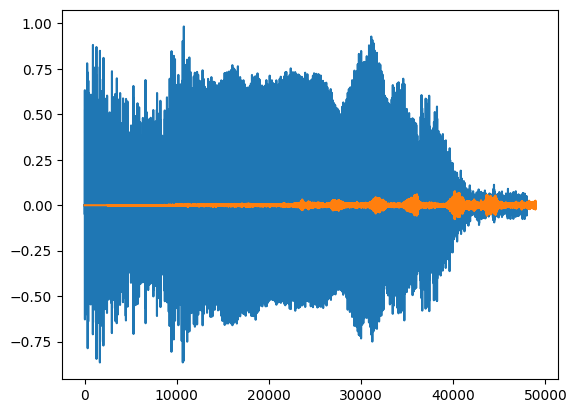

In [79]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Blue one is Capuchin Bird
# Orange one is the background noice

### Creating a Tensorflow Dataset


In [80]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [81]:
# getting each file withing the POS & NEG folders
pos = tf.data.Dataset.list_files(POS + '\*.wav')
neg = tf.data.Dataset.list_files(NEG + '\*.wav')

In [82]:
# Getting a random file -- Just checking
print(pos.as_numpy_iterator().next())
neg.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC216012-11.wav'


b'data\\Parsed_Not_Capuchinbird_Clips\\cricket-sounds-for-sleep-56.wav'

In [83]:
# Assigning a binary number to each pos & neg

# .zip --> is merging two file
# one is pos/neg from earlier 
# and the other is a list of tensors(1, 0) of ones/zeroes of the same length as pos/neg

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [84]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_Clips\\tawny-owl-sounds-7.wav', 0.0)

### Average Length of a Capuchin Call

In [85]:
# storing the lengths of each audio file in 16000 Hz
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

In [86]:
# Mean of the Capuchin Audio is 54,156
tf.reduce_mean(lengths)

# 1 sec = 16000 Hz
# ? sec = 54,156 Hz

# print(54156/16000)
# --> 3.38 seconds for an average of Capuchin Bird Voice

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [87]:
# Max length of the file 
tf.reduce_max(lengths)

# 80,000 Hz

# print(80000/16000)
# --> 5 seconds the maximum duration of Capuchin Bird Voice

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [88]:
# Max length of the file 
tf.reduce_min(lengths)

# 32,000 Hz

# print(32000/16000)
# --> 2 seconds the minimum duration of Capuchin Bird Voice

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [89]:
# Let's take the middle, i.e. 48,000

### Converting the data into a spectogram

In [90]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    # only taking the inputs up until 48000
    wav = wav[:48000]
    # for those files whose lengths are less than 48000, we will fill the remaining spaces with zeroes
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    # tf.signal.stft --> short-time fourier transform
    # frame_length --> specifies the length of each frame in samples
    # Each frame --> 320 samples long || At 16Hz sampling rate
    # Frame Duration = 320/16000 = 0.02 seconds --> 20 milliseconds
    # Signal is divided into 20 ms chunks for analysis.

    # frame step -> how much the window will move forward
    # 32/48000 = 0.002 seconds --> 2 milliseconds
    # Moving the window forward by 2 ms (32 samples) each time.
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # removing any negatives -> absolute values 
    spectogram = tf.abs(spectogram)
    # encapsulate the spectogram in another set of array (for CNN)
    spectogram = tf.expand_dims(spectogram, axis = 2)
    return spectogram, label


In [91]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)

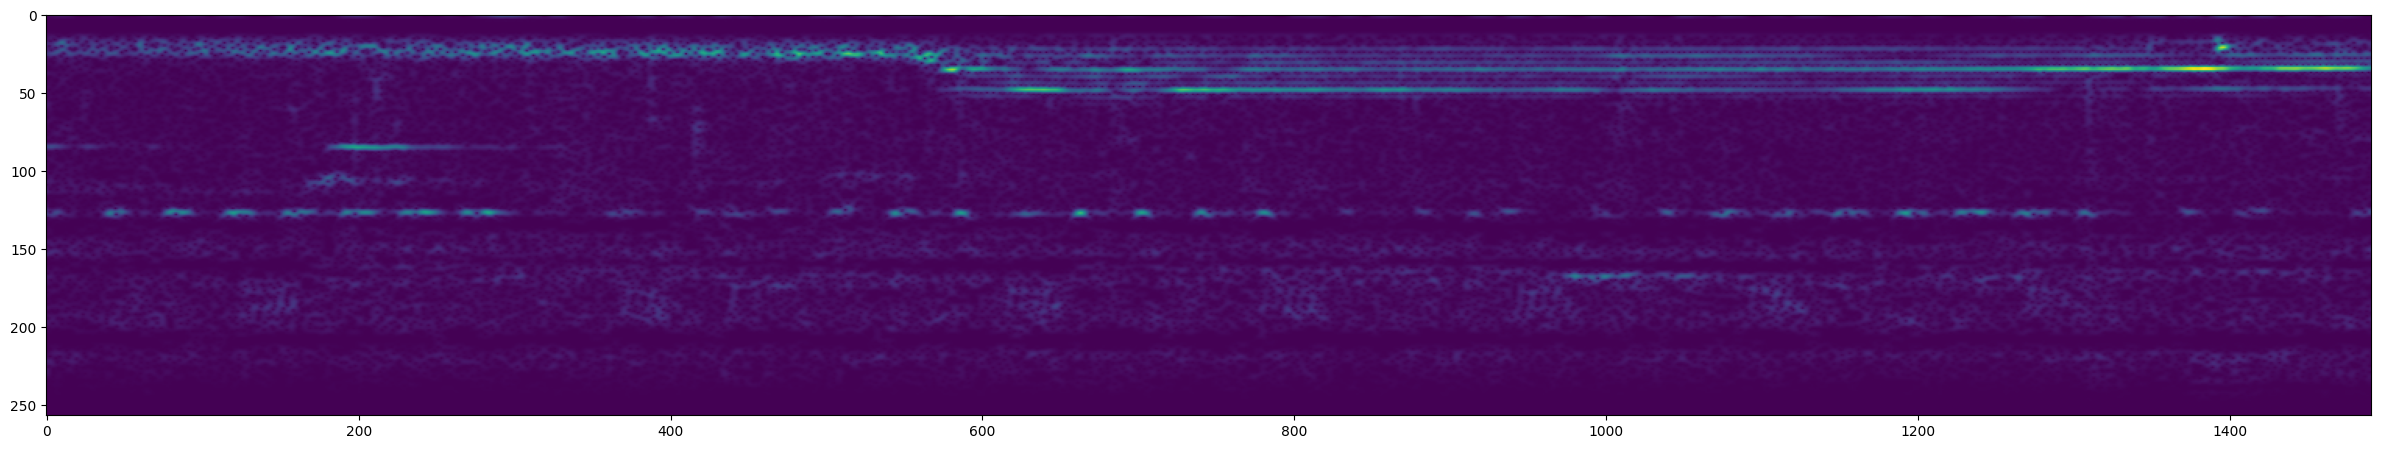

Original:  (1491, 257, 1)
Transpose:  (1, 257, 1491)
To plot the graph:  (257, 1491)


In [92]:
# Visualizing a CAPUCHIN
filepath, label = positives.shuffle(1000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()
print("Original: ", spectogram.shape)
print("Transpose: ", tf.transpose(spectogram).shape)
print("To plot the graph: ", tf.transpose(spectogram)[0].shape)


In [93]:
spectogram, label = preprocess(filepath, label)

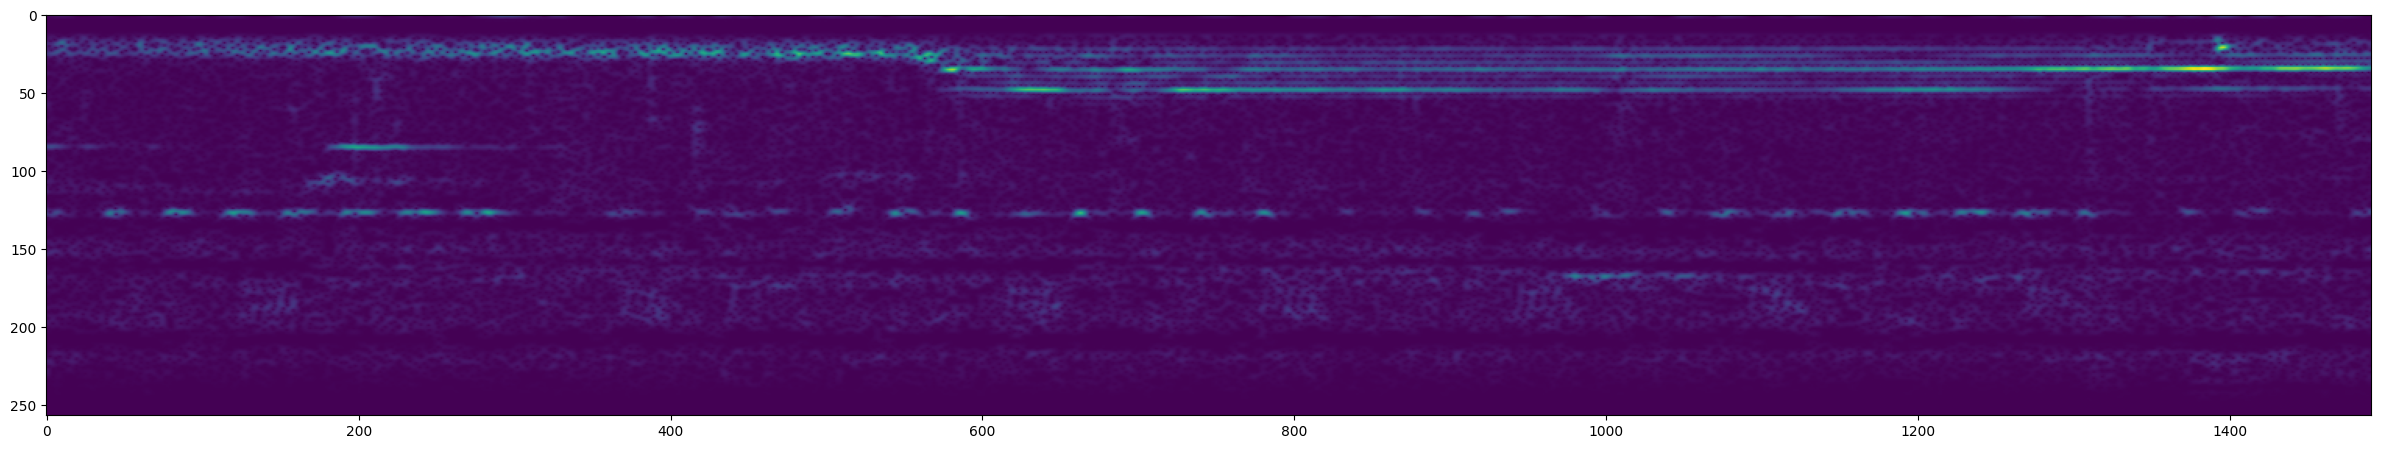

In [94]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

### Create Training and Testing Partitions

In [95]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(8)

In [96]:
split = int(round(len(data) * .7, 0))
train = data.take(split)
test = data.skip(split).take(len(data) - split)

In [97]:
samples, labels = train.as_numpy_iterator().next()

In [98]:
# 16 rows of data, i.e. 16 different examples of our spectogram
samples.shape

(16, 1491, 257, 1)

### Deep Learning Model

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [100]:
tf.keras.backend.clear_session()

In [101]:
model = Sequential()

# 16: Specifies that this layer will produce 16 output feature maps (also called filters).
# (3, 3): Defines the size of the convolutional kernel (filter). It's a 3x3 kernel, meaning it will slide over the input data in a 3x3 window.
model.add(Conv2D(4,(3,3), activation='relu', input_shape= (1491,257,1)))

# no input shape is given cuz model refers to the input shape automatically from the prev layer
model.add(Conv2D(4,(3,3), activation='relu'))
# OUTPUT -> 3D tensor(Height, Width, Number of Filters)

# flattens the multi-dimensional output from the previous layer into a long, single vector 
model.add(Flatten())

# fully connected layer with 128 neurons
# each layer in this neuron is connected to every element in the flattened vector from the prev layer
model.add(Dense(16, activation='relu'))

# final layer with a single neuron
# produces a single output --> 0 or 1 
model.add(Dense(1, activation='sigmoid'))

In [102]:
model.compile('Adam', loss = 'BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 4)      40        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 4)      148       
                                                                 
 flatten (Flatten)           (None, 1504844)           0         
                                                                 
 dense (Dense)               (None, 16)                24077520  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,077,725
Trainable params: 24,077,725
Non-trainable params: 0
_________________________________________________________________


In [104]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 11s 278ms/step - loss: 1.1558 - recall: 0.9038 - precision: 0.6980 - val_loss: 0.1502 - val_recall: 0.8361 - val_precision: 0.9808
Epoch 2/4
36/36 [==============================] - 7s 204ms/step - loss: 0.0585 - recall: 0.9512 - precision: 0.9936 - val_loss: 0.0523 - val_recall: 1.0000 - val_precision: 0.9688
Epoch 3/4
36/36 [==============================] - 7s 204ms/step - loss: 0.0353 - recall: 0.9819 - precision: 0.9760 - val_loss: 0.0034 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 7s 205ms/step - loss: 0.0113 - recall: 0.9804 - precision: 1.0000 - val_loss: 0.0038 - val_recall: 1.0000 - val_precision: 1.0000


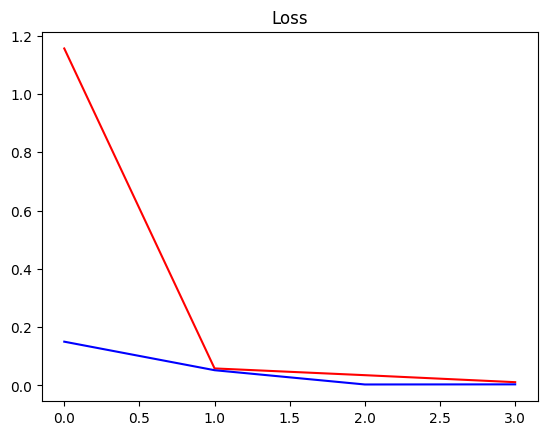

In [108]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

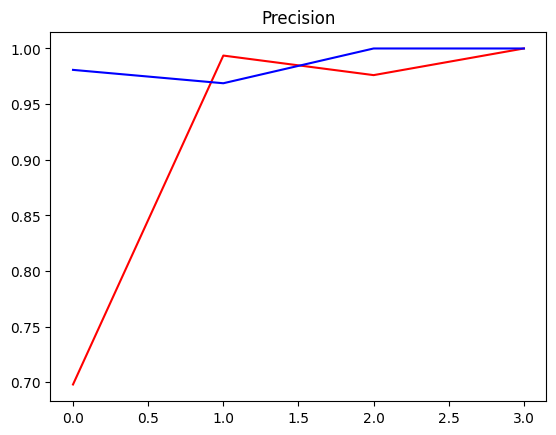

In [109]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

### Make a prediction

In [110]:
x_test, y_test = test.as_numpy_iterator().next()

In [111]:
x_test.shape

(16, 1491, 257, 1)

In [112]:
yhat = model.predict(x_test)

1/1 [==============================] - 0s 107ms/step


In [113]:
yhat

array([[4.7930183e-07],
       [3.2860367e-04],
       [2.8883391e-03],
       [3.4413503e-03],
       [2.4596960e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.3857301e-05],
       [1.9019763e-03],
       [9.4199402e-07],
       [2.9045987e-12],
       [9.9999678e-01],
       [6.1421496e-10],
       [1.5012004e-02],
       [1.0000000e+00]], dtype=float32)

In [114]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [115]:
print("Predicted -->", yhat)
print("Actual    -->", y_test)

Predicted --> [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Actual    --> [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.]


In [116]:
print(tf.math.reduce_sum(yhat))
print(tf.math.reduce_sum(y_test))
# All correct

tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(5.0, shape=(), dtype=float32)


In [117]:
def load_mp3_16k_mono(filename):

        # loads the audio file into the memory
        # res contains audio data and sample_rate
        res = tfio.audio.AudioIOTensor(filename)

        # converts the AudioIOTensor into a full Tensorflow tensor
        tensor = res.to_tensor()
        # OUTPUT --> 2D Tensor where first dimension represent samples, second dimension represent channels
        # channels --> (2: for stereo audio, 1: for mono) 

        # converts the sound from stereo to mono by averaging the channels
        tensor = tf.math.reduce_sum(tensor, axis=1) / 2

        # retrieving the sample rate of the original file
        sample_rate = res.rate
        # converts the sample_rate tensor to a 64-bit integer type 
        # necessary because resampling function expects the sample rate to be an integer
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)

        # resamples the mono audio from its original sample_rate to sample_rate of 16,000 Hz
        wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
        return wav

In [118]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [119]:
wav = load_mp3_16k_mono(mp3)

In [120]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [122]:
samples, index = audio_slices.as_numpy_iterator().next()

In [125]:
# What we have done here is we divided the main mp3 file into 60 different windows
# then we take each of those windows and convert them into a spectogram
# then we loop thru them all to make predictions
len(audio_slices)

60

In [126]:
def preprocess_mp3(sample,index):
    sample = sample[0]
    zero_padding = tf.zeros(48000 - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram

In [127]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [128]:
yhat = model.predict(audio_slices)

1/1 [==============================] - 2s 2s/step


In [129]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [135]:
# it is taking 1,1,1 that is, multiple consecutive 1's for same chirp, so we need to group these
yhat

[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [138]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
tf.reduce_sum(yhat).numpy()

5

### Making prediction for each recoding

In [139]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    yhat = model.predict(audio_slices)
    results[file] = yhat

1/1 [==============================] - 0s 475ms/step


In [153]:
class_pred = {}
for file, logits in results.items():
    class_pred[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
class_pred

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [ ]:
postprocess = {}
for file, scores in class_pred.items():
    postprocess[file] = tf.math.reduce_sum([key for key, group in groupby(scores)])
postprocess

In [ ]:
import csv
with open('Capuchin_Results.csv', 'w', newline='') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerow(['Recording', 'Capuchin Calls'])
    for key, value in postprocess.items():
        writer.writerow([key,value])